<a href="https://colab.research.google.com/github/IndraniMandal/CSC310-S20/blob/master/notes/22a-image-compression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [30]:
###### Set Up #####
# verify our folder with the data and module assets is installed
# if it is installed make sure it is the latest
!test -e ds-assets && cd ds-assets && git pull && cd ..
# if it is not installed clone it
!test ! -e ds-assets && git clone https://github.com/IndraniMandal/ds-assets.git
# point to the folder with the assets
home = "ds-assets/assets/"
import sys
sys.path.append(home)      # add home folder to module search path

Already up to date.


# Image Compression: Color Quantization using k-Means

In computer graphics, **color quantization** is a process that reduces the number of distinct colors used in an image, usually with the intention that the new image should be as visually similar as possible to the original image.

An example image in 24-bit RGB color, <br>
<img src="https://upload.wikimedia.org/wikipedia/commons/e/e3/Dithering_example_undithered.png">

The same image reduced to a palette of 16 colors ,<br>
<img src="https://upload.wikimedia.org/wikipedia/commons/4/48/Dithering_example_undithered_16color_palette.png">

The palette is chosen using the k-means algorithm in RGB color space,<br>
<img src="https://upload.wikimedia.org/wikipedia/commons/3/3d/Rosa_Gold_Glow_2_small_noblue_color_space.png" height="300" width="300">

(source: [Wikipedia](https://en.wikipedia.org/wiki/Color_quantization))

# A Worked Example

Perform a color quantization of an image of Yellowstone, **reducing the number of colors required to show the image from 96,615
unique colors to 8 colors**, while preserving the overall appearance quality as much as possible.

Based on the [quantization example from SKlearn](https://scikit-learn.org/stable/auto_examples/cluster/plot_color_quantization.html#sphx-glr-auto-examples-cluster-plot-color-quantization-py)

In [31]:
import numpy as np # we need access to numpy arrays
import matplotlib.pyplot as plt
from matplotlib.colors import to_hex
from sklearn.cluster import KMeans
from sklearn.utils import shuffle

In [32]:
# number of colors to use for quantization
n_colors = 8

## Image Data

We load a JPEG image from our folder.  **Note**, the technique we present here will work with any JPEG image.

In [33]:
# load the image
img = plt.imread(home+"yellowstone.jpg")
img.shape

(446, 669, 3)

**Observation**: It is a 446x669 image with three integers describing the color at each pixel.

In [34]:
type(img)

numpy.ndarray

In [35]:
# take a look at the top-left pixel
img[0,0,]

array([70, 88, 64], dtype=uint8)

In [36]:
# We need to convert to float [0.0-1.0] for RGB representation otherwise
# pyplot will complain
#img = np.array(img, dtype=np.float64) / 255
img = img / 255
img[0,0,]

array([0.2745098 , 0.34509804, 0.25098039])

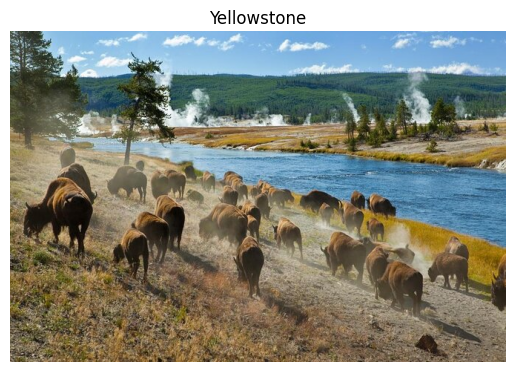

In [37]:
# show the image
plt.clf()
plt.axis('off')
plt.title('Yellowstone')
plt.imshow(img)
plt.show()

## Training Data

Turn the image into training data for our k-means algorithm.  We need to transform the 3D image structure into a 2D training dataset.
The training set is simply a list of all the pixels in 3D RGB color space.

In [38]:
# transform 3D image structure to a 2D numpy array for training the k-means model
# by listing all pixels as a continuous list of color vectors

w, h, d = img.shape
assert d == 3

# the array is now a list of color values: list of points/pixels in RGB space.
pixels = np.reshape(img, (w * h, 3))
pixels[:16,]

array([[0.2745098 , 0.34509804, 0.25098039],
       [0.43529412, 0.50588235, 0.41960784],
       [0.38823529, 0.4627451 , 0.38823529],
       [0.19215686, 0.2745098 , 0.21568627],
       [0.37254902, 0.45098039, 0.41568627],
       [0.44705882, 0.52941176, 0.50980392],
       [0.54117647, 0.62745098, 0.61568627],
       [0.24313725, 0.32941176, 0.32156863],
       [0.18431373, 0.2627451 , 0.25882353],
       [0.29019608, 0.36470588, 0.35686275],
       [0.26666667, 0.32941176, 0.31764706],
       [0.17647059, 0.22745098, 0.2       ],
       [0.18823529, 0.23529412, 0.18823529],
       [0.31372549, 0.35686275, 0.29411765],
       [0.19607843, 0.22352941, 0.15294118],
       [0.25882353, 0.29411765, 0.21960784]])

In [39]:
assert len(pixels) == w*h
len(pixels)

298374

**Observation**: Our image has more than a quarter million pixels.  This is way too much data to train our k-means algorithm.  

We sample the pixels data to create our training data.

In [40]:
# create a 1% sample of the data
assert(len(pixels) > 1000) # make sure there is enough data

sample_size = len(pixels)//100

pixels_sample = shuffle(pixels, random_state=0)[:sample_size]

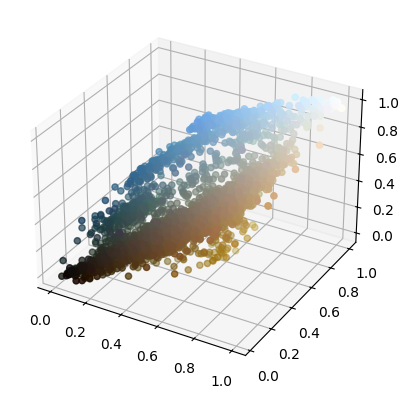

In [41]:
# plot training data in RGB space
plt.figure()
ax = plt.axes(projection='3d')
ax.scatter3D(pixels_sample[:,0],
             pixels_sample[:,1],
             pixels_sample[:,2],
             c=pixels_sample);
plt.show()

### Model Building

The idea is now to use clustering with k centroids to find the k most significant colors in the RGB space.

First, let's take a look at this via the elbow method.

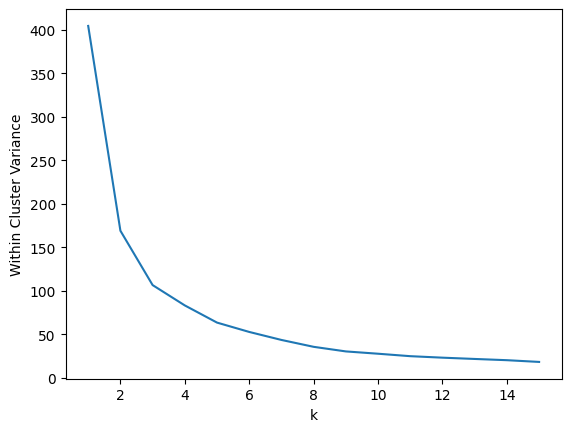

In [42]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import numpy as np
from scipy.spatial.distance import cdist, pdist

def plot_elbow(df, n=10):

    # kmeans models for each k
    kMeansVar = [KMeans(n_clusters=k).fit(df) for k in range(1, n+1)]

    # get the centroids of the models
    centroids = [X.cluster_centers_ for X in kMeansVar]

    # find the distances of the values to the centroids
    k_euclid = [cdist(df, cent) for cent in centroids]

    # find the distance of each point to its cluster center
    dist = [np.min(ke, axis=1) for ke in k_euclid]

    # total within cluster sum of squares
    wcss = [sum(d**2) for d in dist]

    # plot the variance of the models
    plt.plot(list(range(1,n+1)),wcss)
    plt.xlabel('k')
    plt.ylabel('Within Cluster Variance')
    plt.show()

plot_elbow(pixels_sample, n=15)

**Observation**: It is interesting to note that k=8 appears at the upper end of the elbow.  So chosing k=8 is very reasonable. A lower k would mean that we might lose significant color differentiation and a higher k means that we are introducing colors which potentially do not add much more color differentiation to the image.

In [43]:
# train the model with n_colors
model = KMeans(n_clusters=n_colors,  # our 8 colors
               n_init='auto',
               random_state=0)
model.fit(pixels_sample)

# the cluster centers now represent the new colors
centroid_pixels = model.cluster_centers_
centroid_pixels

array([[0.46053385, 0.38452841, 0.24599971],
       [0.53350065, 0.71619346, 0.86091503],
       [0.2685356 , 0.31999521, 0.27716944],
       [0.7017507 , 0.65552054, 0.55324463],
       [0.58542507, 0.51119134, 0.37998867],
       [0.32867317, 0.51048976, 0.62270289],
       [0.18706361, 0.16892635, 0.09967719],
       [0.79960172, 0.86712623, 0.88869485]])

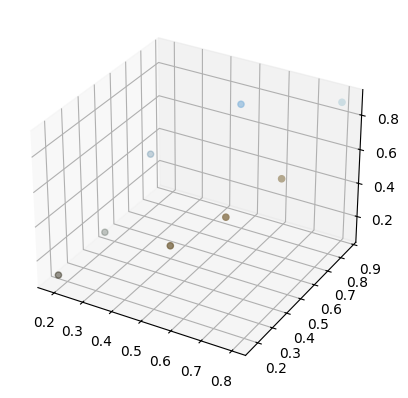

In [44]:
# plot the colors of the k-means model
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.scatter3D(centroid_pixels[:,0],
             centroid_pixels[:,1],
             centroid_pixels[:,2],
             c=centroid_pixels)
plt.show()

### Build Compressed Image

Now we map every pixel in our pixels array to our of our centroids.  In effect, we are replacing the pixel color with the corresponding centroid color.

In [45]:
# map each pixel in our pixels array to a centroid
pixel_centroid_labels = model.predict(pixels)

# show a random sample of the centroid labels
shuffle(pixel_centroid_labels)[:10]

array([3, 4, 5, 0, 6, 3, 4, 1, 0, 1], dtype=int32)

In [46]:
# create a new pixels array based on the color centroid
new_pixels = np.zeros((w*h,3)) # initialize the new pixes with zeros

# map the original pixels into new pixels based on the
# assigned centroid RGB value
for i in range(w*h):
    new_pixels[i] = centroid_pixels[pixel_centroid_labels[i]]

In [47]:
# reshape the new pixel array into a new image with the same dimensions as the original image.
new_img = np.reshape(new_pixels,(w,h,3))

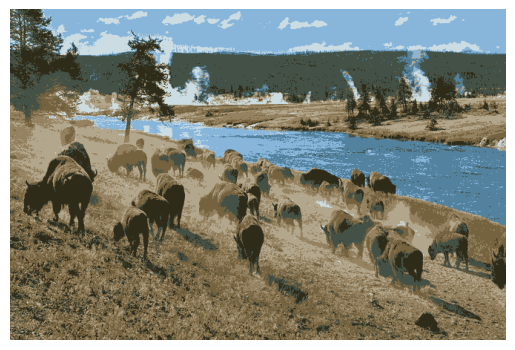

In [48]:
# show the new image
plt.clf()
plt.axis('off')
plt.imshow(new_img)
plt.show()

**Observation**: Nothing drastic happened to the image!

### Image Comparison

Not only do we show the original and the compressed image but we also save them to files so we can look at the effect that color quantization has on image file size.

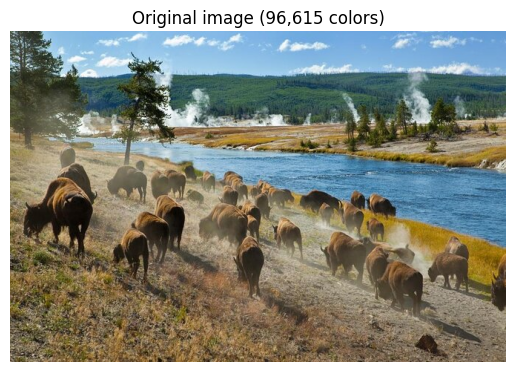

In [49]:
# original image
plt.clf()
plt.axis('off')
plt.title('Original image (96,615 colors)')
plt.imshow(img)
plt.savefig("original.png")
plt.show()

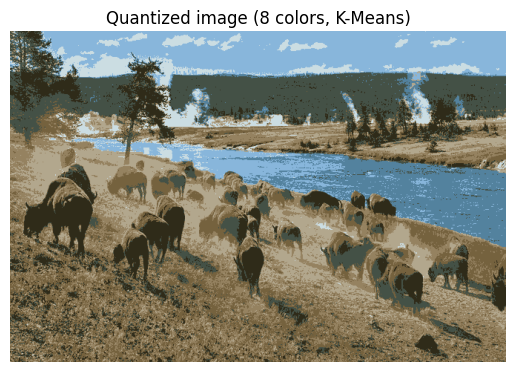

In [50]:
# quantized image
plt.clf()
plt.axis('off')
plt.title('Quantized image ({} colors, K-Means)'.format(n_colors))
plt.imshow(new_img)
plt.savefig("compressed.png")
plt.show()

The sizes of the files are shown in KBytes.

In [51]:
!ls -s -k original.png
!ls -s -k compressed.png

376 original.png
296 compressed.png
